In [1]:
from scipy.sparse import csc_matrix
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import umap
import hdbscan

/Users/cmdb/mambaforge/envs/scRNA_ASJ_PCA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
matrix_geneData = mmread('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/DATA/Taylor_etal_scRNA/GSE136049_gene_by_barcode_count_matrix_all_cells.mtx')
print(matrix_geneData.shape)
#Convert the matrix to a compressed sparse column (CSC) matrix format in order to do indexing operations
matrix_geneData_csc = csc_matrix(matrix_geneData)
geneKey = pd.read_csv('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/DATA/Taylor_etal_scRNA/GSE136049_cell_type_annotation_lookup_table.csv')
print(len(geneKey))


#list of ALL cell barcodes
barcode_list = geneKey['barcode'].tolist()
#Creating a dictionary mapping each barcode to its index (row #)
bracodeIndex = {barcode: index for index, barcode in enumerate(barcode_list)}


#filtering out only ASJ cells (they aren't specified as left or right... that is what we are trying to visualize!)
ASJ_cells_key = geneKey[geneKey['cell.type'] == 'ASJ'] 
#list of ASJ cell barcodes
ASJ_cell_ids = ASJ_cells_key['barcode'].tolist()
#Get the indices of ASJ cells in the barcode list
ASJ_cell_indices = [bracodeIndex[barcode] for barcode in ASJ_cell_ids] 


#Extract the gene expression data for ASJ cells from sparse matrix
ASJ_geneData = matrix_geneData_csc[:, ASJ_cell_indices] #this is assuming that the order of genes (barcodes) are the same for the rows in geneKey and the columns in the matrix_geneData
# print(ASJ_geneData)

(22469, 100955)
100955


<font color='red' size = 6>Isolating cell-speciifc expression data of genes used to classify cells</font>

In [9]:
## Get indexes of cell-specific genes - highly expressed???? ##
GeneList = pd.read_csv("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/DATA/Taylor_etal_scRNA/GSE136049_all_cells_gene_annotations.csv")
# print(GeneList.head(5))
trx1_geneIndex = GeneList.loc[GeneList['WBGene00010957'] == 'WBGene00015062'].index[0] # index value of 20768 - trx-1 gene used to identify ASJ cells
# print(GeneList['WBGene00010957'][20768])

ASJ_geneData_trx1_expressionData = ASJ_geneData[trx1_geneIndex].toarray() #assuming that the gene index is the same for the rows in GeneList and the rows in ASJ_geneData
# print(len(ASJ_geneData_trx1_expressionData[0])) #1266 ASJ cells

count = 0
count_HIGH = 0
for i in ASJ_geneData_trx1_expressionData[0]:
    if i > 0:
        count += 1   

# print(count) # number of ASJ cells that express trx-1 gene
# Which is 70.......



# AVA neruon stuff #
AVA_cells_key = geneKey[geneKey['cell.type'] == 'AVA'] 
AVA_cell_ids = AVA_cells_key['barcode'].tolist()
AVA_cell_indices = [bracodeIndex[barcode] for barcode in AVA_cell_ids] 
#Extract the gene expression data for AVA cells from sparse matrix
AVA_geneData = matrix_geneData_csc[:, AVA_cell_indices]

glr1_geneIndex = GeneList.loc[GeneList['WBGene00010957'] == 'WBGene00001612'].index[0] # index value of 5583 - glr-1 gene used to identify ASJ cells
# print(GeneList['WBGene00010957'][5583])

AVA_geneData_glr1_expressionData = AVA_geneData[glr1_geneIndex].toarray() #assuming that the gene index is the same for the rows in GeneList and the rows in AVA_geneData
# print(len(AVA_geneData_glr1_expressionData[0])) # 673 AVA cells
# print(AVA_geneData_glr1_expressionData[0])

count = 0
count_HIGH = 0
for i in AVA_geneData_glr1_expressionData[0]:
    if i > 0:
        count += 1   

# print(count) # number of AVA cells that express glr-1 gene
# Which is 0.......


nmr1_geneIndex = GeneList.loc[GeneList['WBGene00010957'] == 'WBGene00003774'].index[0] # index value of 20099  - nmr-1 gene used to identify ASJ cells
# print(GeneList['WBGene00010957'][20099])

AVA_cells = AVA_geneData[nmr1_geneIndex].toarray() #assuming that the gene index is the same for the rows in GeneList and the rows in AVA_geneData
# print(len(AVA_geneData_nmr1_expressionData[0])) # 673 AVA cells
# print(AVA_geneData_nmr1_expressionData[0])

cellsExpressing_nmr1 = 0
for nmr1_gene_expression in AVA_cells[0]:
    if nmr1_gene_expression > 0:
        cellsExpressing_nmr1 += 1   

print(cellsExpressing_nmr1) # number of AVA cells that express nmr-1 gene marker for identification

0


<font color='red' size = 6>Extracting all LABELED cells from the sparse matrix, and performing UMAP</font>

In [4]:
matrix_geneData = mmread('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/DATA/Taylor_etal_scRNA/GSE136049_gene_by_barcode_count_matrix_all_cells.mtx')
print(matrix_geneData.shape)
#Convert the matrix to a compressed sparse column (CSC) matrix format in order to do indexing operations
matrix_geneData_csc = csc_matrix(matrix_geneData)
geneKey = pd.read_csv('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/DATA/Taylor_etal_scRNA/GSE136049_cell_type_annotation_lookup_table.csv')
print(len(geneKey))


#list of ALL cell barcodes
barcode_list = geneKey['barcode'].tolist()
#Creating a dictionary mapping each barcode to its index (row #)
bracodeIndex = {barcode: index for index, barcode in enumerate(barcode_list)}


#filtering out only Neuron-labeled cells 
LABELED_cells_key = geneKey[geneKey['tissue.type'] == 'Neuron'] 
#list of LABELED cell barcodes
LABELED_cell_ids = LABELED_cells_key['barcode'].tolist()
#Get the indices of LABELED cells in the barcode list
LABELED_cell_indices = [bracodeIndex[barcode] for barcode in LABELED_cell_ids] 


#Extract the gene expression data for LABELED cells from sparse matrix
LABELED_geneData = matrix_geneData_csc[:, LABELED_cell_indices] #this is assuming that the order of genes (barcodes) are the same for the rows in geneKey and the columns in the matrix_geneData
print(LABELED_geneData.shape) # 70296 cells out of the 100955 cells are labeled as Neurons

(22469, 100955)
100955
(22469, 70296)


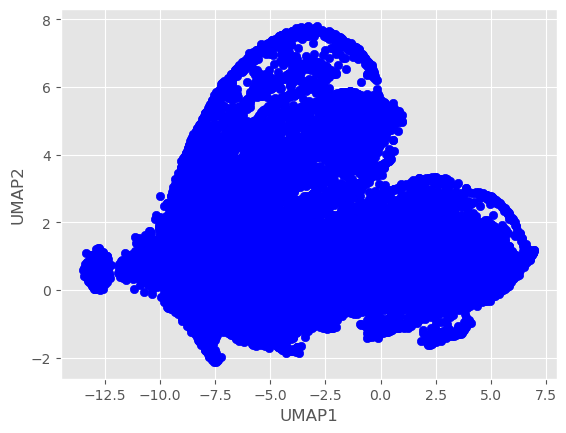

In [8]:
pca = PCA(n_components=135)
pca_result = pca.fit_transform(LABELED_geneData.toarray())

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=75, min_dist=0.3, n_components=2)
umap_result = umap_model.fit_transform(pca_result)

# Plot the result
plt.style.use("ggplot")
plt.scatter(umap_result[:,0], umap_result[:,1], color = 'blue')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/UMAP_scRNA_data.png", dpi = 900)
plt.show()

# umap_model_labeled_15_23 = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
# umap_result_labeled23 = umap_model_labeled_15_23.fit_transform(LABELED_geneData)

# plt.style.use("ggplot")
# plt.title("All labeled")
# plt.scatter(umap_result_labeled23[:,1], umap_result_labeled23[:,2], color = 'blue', label = '# neighbors = 15')
# plt.xlabel("UMAP2")
# plt.ylabel("UMAP3")
# plt.legend()
# plt.show()


# umap_model_labeled_25 = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=3)
# umap_result_labeled_12_25 = umap_model_labeled_25.fit_transform(LABELED_geneData)

# plt.style.use("ggplot")
# plt.title("All labeled")
# plt.scatter(umap_result_labeled_12_25[:,0], umap_result_labeled_12_25[:,1], color = 'blue', label = '# neighbors = 25')
# plt.xlabel("UMAP1")
# plt.ylabel("UMAP2")
# plt.legend()
# plt.show()

# umap_model_labeled_5 = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
# umap_result_labeled_12_5 = umap_model_labeled_5.fit_transform(LABELED_geneData)

# plt.style.use("ggplot")
# plt.title("All labeled")
# plt.scatter(umap_result_labeled_12_5[:,0], umap_result_labeled_12_5[:,1], color = 'blue', label = '# neighbors = 5')
# plt.xlabel("UMAP1")
# plt.ylabel("UMAP2")
# plt.legend()
# plt.show()

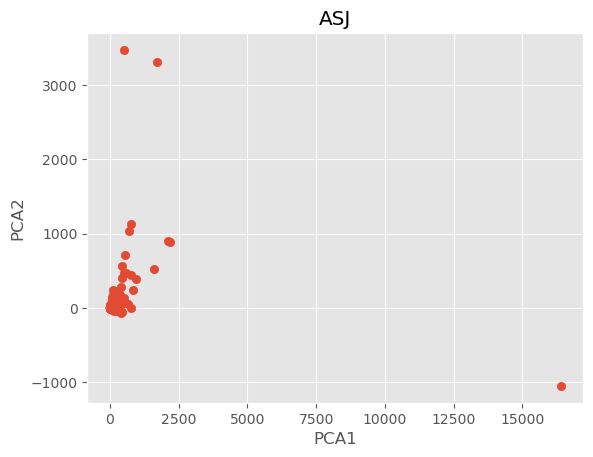

In [ ]:
#converting the sparse matrix to a dense matrix
ASJ_geneData_dense = ASJ_geneData.toarray()

pca2 = PCA(n_components=2)
pca_result_ASJ2 = pca2.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.title("ASJ")
plt.scatter(pca_result_ASJ2[:,0], pca_result_ASJ2[:,1])
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

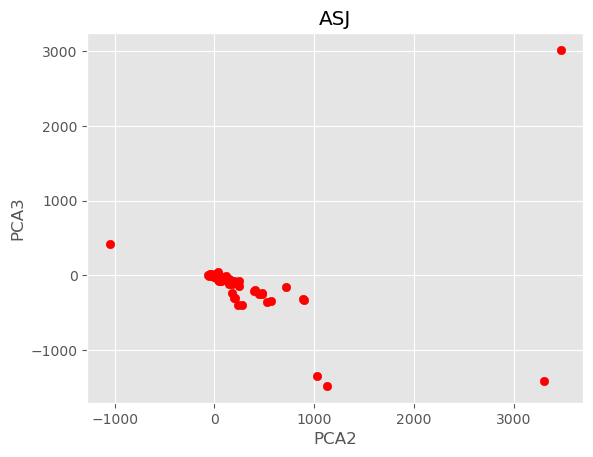

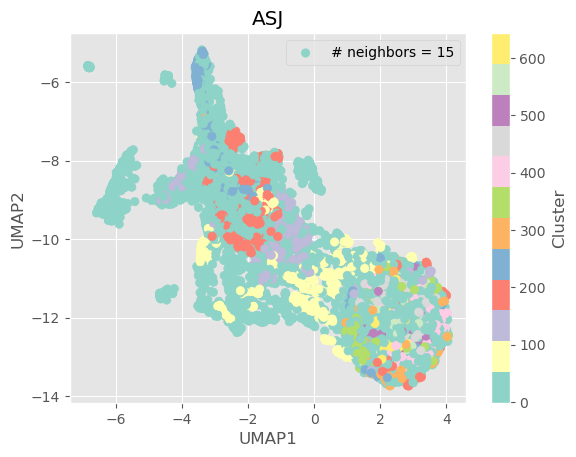

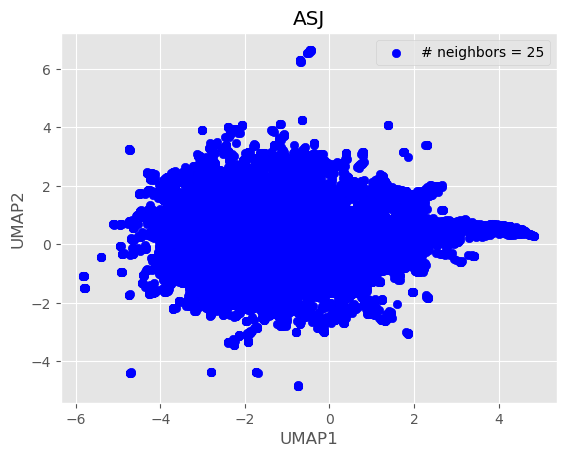

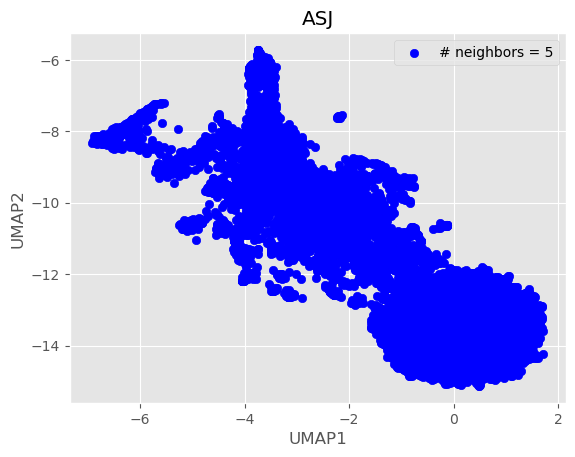

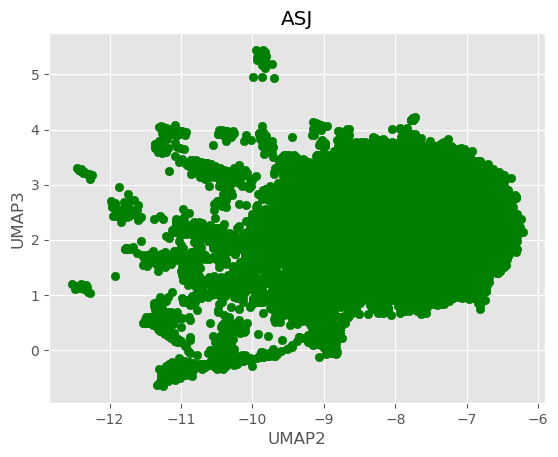

In [ ]:
# plotting components 2 and 3 instead of 1 and 2
pca3 = PCA(n_components=3)
pca_result_ASJ3 = pca3.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.title("ASJ")
plt.scatter(pca_result_ASJ3[:,1], pca_result_ASJ3[:,2], color = 'red')
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.show()


umap_model_15 = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_result_ASJ12 = umap_model_15.fit_transform(ASJ_geneData_dense)
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)  # Adjust min_cluster_size as needed
clusters = clusterer.fit_predict(umap_result_ASJ12)

plt.style.use("ggplot")
plt.title("ASJ")
plt.scatter(umap_result_ASJ12[:,0], umap_result_ASJ12[:,1], c = clusters, cmap = 'Set3', label = '# neighbors = 15')
plt.colorbar(label='Cluster')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.show()

umap_model_25 = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=3)
umap_result_ASJ12_25 = umap_model_25.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.title("ASJ")
plt.scatter(umap_result_ASJ12_25[:,0], umap_result_ASJ12_25[:,1], color = 'blue', label = '# neighbors = 25')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.show()

umap_model_5 = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
umap_result_ASJ12_5 = umap_model_5.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.title("ASJ")
plt.scatter(umap_result_ASJ12_5[:,0], umap_result_ASJ12_5[:,1], color = 'blue', label = '# neighbors = 5')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.show()





umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
umap_result_ASJ3 = umap_model.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.title("ASJ")
plt.scatter(umap_result_ASJ3[:,1], umap_result_ASJ3[:,2], color = 'green')
plt.xlabel("UMAP2")
plt.ylabel("UMAP3")
plt.show()



# pca4 = PCA(n_components=4)
# pca_result_ASJ4 = pca4.fit_transform(ASJ_geneData_dense)

# plt.style.use("ggplot")
# plt.title("ASJ")
# plt.scatter(pca_result_ASJ4[:,2], pca_result_ASJ4[:,3], color = 'blue')
# plt.xlabel("PCA3")
# plt.ylabel("PCA4")
# plt.show()

In [87]:
#Isolating AVA cell data too, and then plotting PCA 
AVA_cells_key = geneKey[geneKey['cell.type'] == 'AVA'] 
#list of ASJ cell barcodes
AVA_cell_ids = AVA_cells_key['barcode'].tolist()
#Get the indices of AVA cells in the barcode list
AVA_cell_indices = [bracodeIndex[barcode] for barcode in AVA_cell_ids] 

#Extract the gene expression data for AVA cells from sparse matrix
AVA_geneData = matrix_geneData_csc[:, AVA_cell_indices]

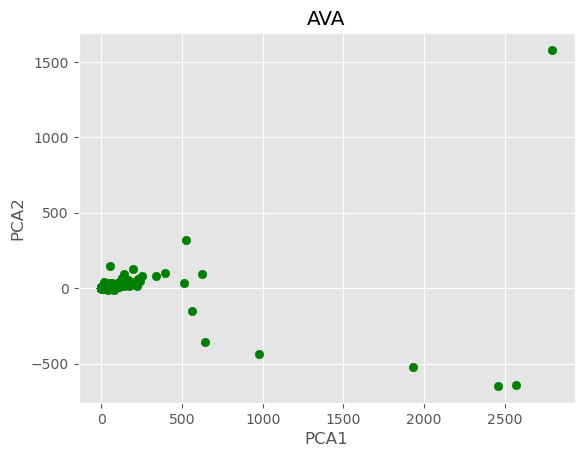

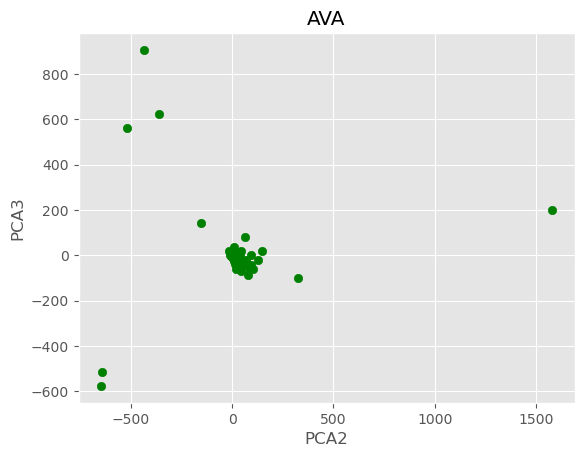

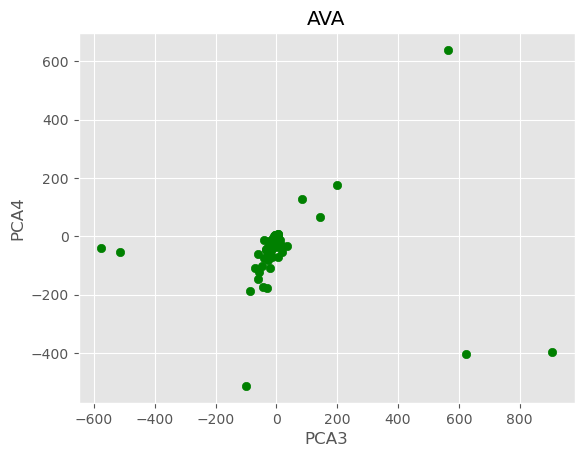

In [88]:
#converting the sparse matrix to a dense matrix
AVA_geneData_dense = AVA_geneData.toarray()

pca2 = PCA(n_components=2)
pca_result_AVA2 = pca2.fit_transform(AVA_geneData_dense)

plt.style.use("ggplot")
plt.title("AVA")
plt.scatter(pca_result_AVA2[:,0], pca_result_AVA2[:,1], color = 'green')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

pca3 = PCA(n_components=3)
pca_result_AVA3 = pca3.fit_transform(AVA_geneData_dense)

plt.style.use("ggplot")
plt.title("AVA")
plt.scatter(pca_result_AVA3[:,1], pca_result_AVA3[:,2], color = 'green')
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.show()

pca4 = PCA(n_components=4)
pca_result_AVA4 = pca4.fit_transform(AVA_geneData_dense)
plt.title("AVA")

plt.style.use("ggplot")
plt.scatter(pca_result_AVA4[:,2], pca_result_AVA4[:,3], color = 'green')
plt.xlabel("PCA3")
plt.ylabel("PCA4")
plt.show()

In [89]:
#Isolating AWA cell data too, and then plotting PCA 
AWA_cells_key = geneKey[geneKey['cell.type'] == 'AWA'] 
#list of ASJ cell barcodes
AWA_cell_ids = AWA_cells_key['barcode'].tolist()
#Get the indices of AWA cells in the barcode list
AWA_cell_indices = [bracodeIndex[barcode] for barcode in AWA_cell_ids] 

#Extract the gene expression data for AWA cells from sparse matrix
AWA_geneData = matrix_geneData_csc[:, AWA_cell_indices]

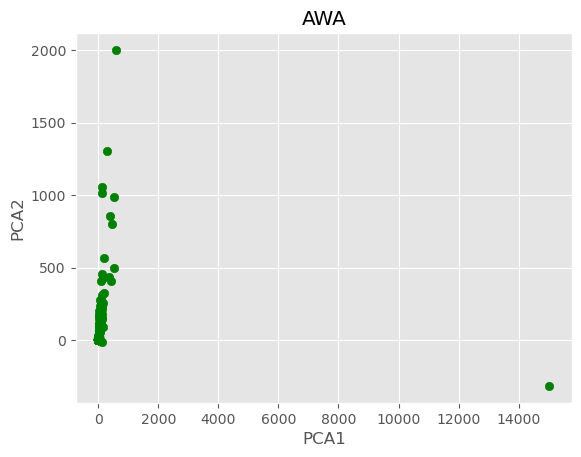

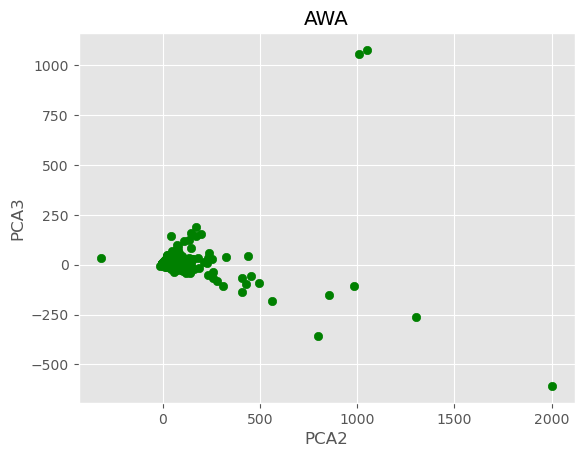

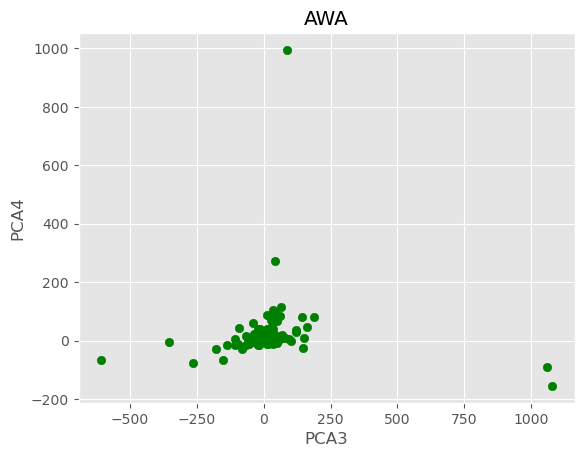

In [90]:
AWA_geneData_dense = AWA_geneData.toarray()

pca2 = PCA(n_components=2)
pca_result_AWA_2 = pca2.fit_transform(AWA_geneData_dense)

plt.style.use("ggplot")
plt.title("AWA")
plt.scatter(pca_result_AWA_2[:,0], pca_result_AWA_2[:,1], color = 'purple')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

pca3 = PCA(n_components=3)
pca_result_AWA_3 = pca3.fit_transform(AWA_geneData_dense)

plt.style.use("ggplot")
plt.title("AWA")
plt.scatter(pca_result_AWA_3[:,1], pca_result_AWA_3[:,2], color = 'purple')
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.show()

pca4 = PCA(n_components=4)
pca_result_AWA_4 = pca4.fit_transform(AWA_geneData_dense)
plt.title("AWA")

plt.style.use("ggplot")
plt.scatter(pca_result_AWA_4[:,2], pca_result_AWA_4[:,3], color = 'purple')
plt.xlabel("PCA3")
plt.ylabel("PCA4")
plt.show()

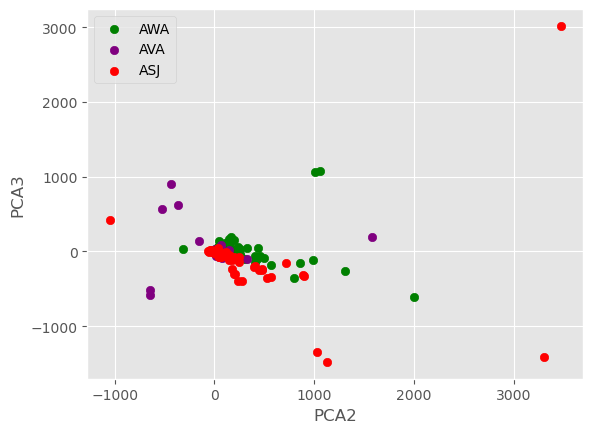

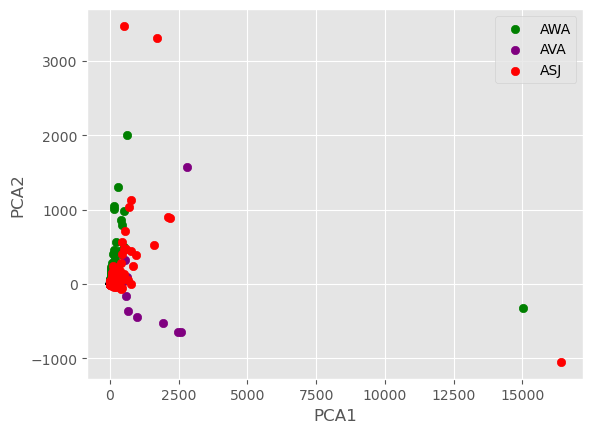

In [96]:
pca3 = PCA(n_components=3)
pca_result_AWA = pca3.fit_transform(AWA_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_AWA[:,1], pca_result_AWA[:,2], color = 'green', label = "AWA")
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.legend()

pca_result_AVA = pca3.fit_transform(AVA_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_AVA[:,1], pca_result_AVA[:,2], color = 'purple', label = "AVA")
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.legend()

pca_result_ASJ = pca3.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_ASJ[:,1], pca_result_ASJ[:,2], color = 'red', label = 'ASJ')
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.legend()
plt.show()


pca2 = PCA(n_components=2)
pca_result_AWA_2 = pca2.fit_transform(AWA_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_AWA_2[:,0], pca_result_AWA_2[:,1], color = 'green', label = "AWA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()

pca_result_AVA_2 = pca2.fit_transform(AVA_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_AVA_2[:,0], pca_result_AVA_2[:,1], color = 'purple', label = "AVA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()

pca_result_ASJ_2 = pca2.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_ASJ_2[:,0], pca_result_ASJ_2[:,1], color = 'red', label = 'ASJ')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()
